Notebook purpose

- Explore whether I can see fresh-start effect in the data

In [56]:
import os
import sys

import linearmodels as lm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns
import statsmodels.formula.api as smf

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.data.txn_classifications as tc
import entropy.figures as figs
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## MDB data

### Load data

In [2]:
dfs, dfl = hd.read_samples(["777", "XX7"])
hd.inspect(dfl)

Time for read_sample    : 1.76 seconds
Time for read_sample    : 4.34 minutes
(16,074,957, 31)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,entropy_sptac
0,1088993,2012-04-02,57,23.74,1982 01apr 12 the broadway fruiterer london gb,NaN,NaN,NaN,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2016-10-30,273998,2015-08-15 21:37:00,natwest bank,current,2014-07-18,2017-10-23,True,NaN,NaN,NaN,NaN,NaN,u,201204,NaN,22542.600586,2.425209
1,1088994,2012-04-02,57,25.68,1982 01apr 12 waitrose 835 crouch end gb,waitrose,spend,household,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2016-10-30,273998,2015-08-15 21:37:00,natwest bank,current,2014-07-18,2017-08-15,True,NaN,waitrose,"food, groceries, household",NaN,supermarket,u,201204,NaN,22542.600586,2.425209


## Analysis

In [131]:
def make_data(df, start=None, end=None):
    df = df.copy()

    # use online banks only, since for other banks, date of txns doesn't
    # equal date when purchase actually happened, esp. around weekends
    online_banks = ["starling bank", "revolut", "monzo"]
    df = df[df.account_provider.isin(online_banks)]

    fast_food_merchs = [
        "mcdonalds",
        "kfc",
        "burger king",
        "five guys",
    ]
    mask = df.merchant.isin(fast_food_merchs)
    df["fast_food"] = df.amount.where(mask, np.nan)
    df = (
        df.groupby("date")
        .fast_food.agg([("txns", "count"), ("spend", "sum")])
        .reset_index()
    )

    df["moy"] = df.date.dt.month
    df["dom"] = df.date.dt.day
    df["dow"] = df.date.dt.dayofweek + 1
    return df.set_index("date").loc[start:end]


df = make_data(dfl, start=None, end=None)
hd.inspect(df)

(1,144, 5)


,txns,spend,moy,dom,dow
date,,,,,
2017-05-20,0,0.0,5,20,6
2017-05-27,0,0.0,5,27,6


In [141]:
from stargazer.stargazer import Stargazer

results = []
for y in ["txns", "spend"]:
    results.append(smf.ols(f"{y} ~ 1 + dom", data=df).fit())
    results.append(smf.ols(f"{y} ~ 1 + dow", data=df).fit())
    results.append(smf.ols(f"{y} ~ 1 + moy", data=df).fit())
    results.append(smf.ols(f"{y} ~ 1 + dow + dom + moy", data=df).fit())
Stargazer(results)

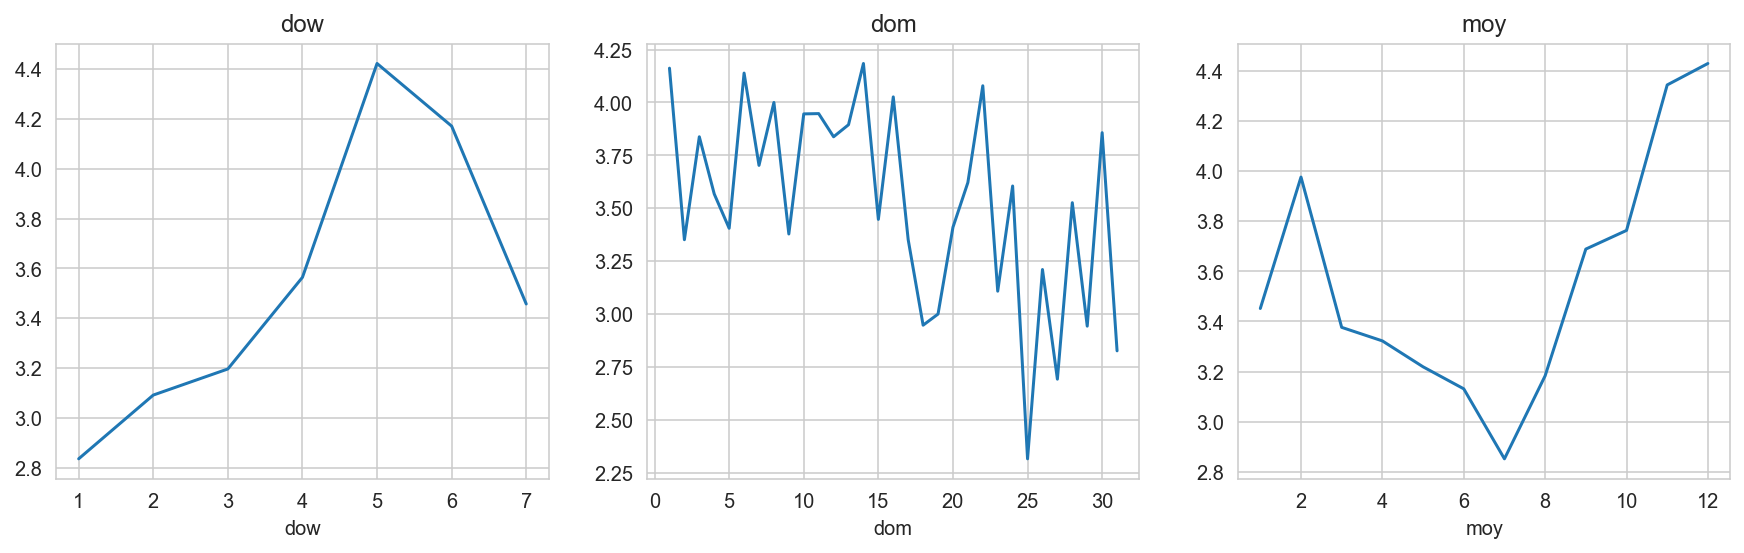

In [144]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

variables = ["dow", "dom", "moy"]
for idx, v in enumerate(variables):
    df.groupby(v).txns.mean().plot(ax=ax[idx])
    ax[idx].set_title(v)

### Discussion

- While aggregate regression results for dow and moy are consistent with the idea of a fresh start, the plots definitely aren't: dow suggests that people buy fast food on Fri and Sat (not surprising at all), moy suggests that they buy less fast food in summer.

## Fable data